In [ ]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
import json # library to handle JSON files
import bs4 as bs
import urllib.request

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

# geocoder
!conda install -c conda-forge geocoder --yes 
import geocoder

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print('Libraries imported.')

<b>1. Build the dataframe for the Toronto Neighbourhoods using BeautifulSoup.</b>

In [2]:
# Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

table = soup.find('table')
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [3]:
df = pd.DataFrame(l, columns=["PostalCode", "Borough", "Neighbourhood"])
df.head(10)

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


<b>1.1 Clean up the dataframe for the Toronto neighbourhood.</b>

In [4]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']
df.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


In [5]:
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
df.loc[df['Neighbourhood']=='Not assigned', ['Neighbourhood']] = 'Queen\'s Park'
df.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


<b>2. Build the dataframe for Toronto neighbourhood population</b>

In [6]:
# Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org
url='https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
skip_table = 1

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

table = soup.find_all('table')[skip_table]
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    #print (tr)
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [7]:
df1 = pd.DataFrame(l, columns=["Neighbourhood", "FM", "Census", "Population", "Land Area", "Density", "Population %", "Income", "Commuting", "Renters", "2nd Language", "2nd Language %"])

# clean up the data and dropping unwanted columns
df1 = df1[df1.Neighbourhood != 'Toronto CMA Average']
df1 = df1.drop('FM', 1)
df1 = df1.drop('Census', 1)
df1 = df1.drop('Renters', 1)

# change to the proper datatype
df1['Population'] = df1['Population'].str.replace(',','')
df1['Population'] = df1['Population'].apply(pd.to_numeric)
#print (df1.dtypes)

# display sample data
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese
2,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish
3,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese
4,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian
5,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish
6,Armour Heights,4384,2.29,1914,2.0,"116,651",10.8,Russian (9.4%),09.4% Russian
7,Banbury,6641,2.72,2442,5.0,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese
8,Bathurst Manor,14945,4.69,3187,12.3,"34,169",13.4,Russian (9.5%),09.5% Russian
9,Bay Street Corridor,4787,0.11,"43,518",3.0,"40,598",17.1,Mandarin (9.6%),09.6% Mandarin
10,Bayview Village,12280,4.14,"2,966",41.6,"46,752",14.4,Cantonese (8.4%),08.4% Cantonese


In [8]:
# get the data size
df.shape
df1.shape

(174, 9)

In [9]:
df1['Latitude'] = ''
df1['Longitude'] = ''

# dummy values in case that geocoder is not working for the day
#df1['Latitude'] = 43.638093
#df1['Longitude'] = -79.4665843

<b>3. Find out the latitude and longitude for each neighbourhood.</b>

In [10]:
# loop through the postal code to find out the latitude and longitude
for index, data in df1.iterrows():
    lat_lng_coords = None
    #print ('Now at PostalCode:', data['PostalCode'])
    #print ('Now at Neighbourhood:', data['Neighbourhood'])
    while(lat_lng_coords is None):
        #g = geocoder.google('{}, Toronto, Ontario'.format(data['PostalCode']))
        g = geocoder.google('{}, Toronto, Ontario'.format(data['Neighbourhood']))
        lat_lng_coords = g.latlng
    data['Latitude'] = lat_lng_coords[0]
    data['Longitude'] = lat_lng_coords[1]
    print ('Neighbourhood:', data['Neighbourhood'], 'Latitude:', data['Latitude'], 'Longitude:', data['Longitude'])
    
# loop through the postal code to find out the latitude and longitude
for index, data in df.iterrows():
    lat_lng_coords = None
    print ('Now at PostalCode:', data['PostalCode'])
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(data['PostalCode']))
        lat_lng_coords = g.latlng
    data['Latitude'] = lat_lng_coords[0]
    data['Longitude'] = lat_lng_coords[1]
    print ('PostalCode:', data['PostalCode'], 'Latitude:', data['Latitude'], 'Longitude:', data['Longitude'])

Neighbourhood: Agincourt Latitude: 43.788009 Longitude: -79.283882
Neighbourhood: Alderwood Latitude: 43.6035413 Longitude: -79.5464093
Neighbourhood: Alexandra Park Latitude: 43.6497781 Longitude: -79.4014566
Neighbourhood: Allenby Latitude: 43.7077457 Longitude: -79.41271429999999
Neighbourhood: Amesbury Latitude: 43.7010934 Longitude: -79.48100649999999
Neighbourhood: Armour Heights Latitude: 43.7453882 Longitude: -79.4225637
Neighbourhood: Banbury Latitude: 43.7491152 Longitude: -79.3663593
Neighbourhood: Bathurst Manor Latitude: 43.7627405 Longitude: -79.45632499999999
Neighbourhood: Bay Street Corridor Latitude: 43.6567308 Longitude: -79.3834603
Neighbourhood: Bayview Village Latitude: 43.778243 Longitude: -79.3827578
Neighbourhood: Bayview Woods – Steeles Latitude: 43.7964111 Longitude: -79.385975
Neighbourhood: Bedford Park Latitude: 43.7301254 Longitude: -79.4113072
Neighbourhood: Bendale Latitude: 43.765434 Longitude: -79.248935
Neighbourhood: Birch Cliff Latitude: 43.6875 Lo

<b>3.1 Print out the updated dataframe.</b>

In [23]:
# print out the updated dataframe
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.788,-79.2839
2,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,43.6035,-79.5464
3,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,43.6498,-79.4015
4,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,43.7077,-79.4127
5,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,43.7011,-79.481
6,Armour Heights,4384,2.29,1914,2.0,"116,651",10.8,Russian (9.4%),09.4% Russian,43.7454,-79.4226
7,Banbury,6641,2.72,2442,5.0,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese,43.7491,-79.3664
8,Bathurst Manor,14945,4.69,3187,12.3,"34,169",13.4,Russian (9.5%),09.5% Russian,43.7627,-79.4563
9,Bay Street Corridor,4787,0.11,"43,518",3.0,"40,598",17.1,Mandarin (9.6%),09.6% Mandarin,43.6567,-79.3835
10,Bayview Village,12280,4.14,"2,966",41.6,"46,752",14.4,Cantonese (8.4%),08.4% Cantonese,43.7782,-79.3828


<b>3.2 Double check on the data quality of the dataframe.</b>

In [24]:
# double check on the dataframe
print('The dataframe has {} neighborhoods.'.format(
        len(df1['Neighbourhood'].unique()),
        df1.shape[0]
    )
)

The dataframe has 174 neighborhoods.


<b>3.3 Add the population weightage for each neighbourhood.</b>

In [25]:
total_population = df1['Population'].sum()
#print (total_population)

# the higher populated neighbourhood will have the higher score
df1['Population Score'] = df1['Population']/total_population*100

# sort the dataframe based on the descending population score
df1 = df1.sort_values('Population Score', ascending=False)
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.6964,-79.3297,2.161626
170,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7675,-79.2177,2.007928
50,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7511,-79.5098,1.987065
86,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.796,-79.309,1.898439
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.788,-79.2839,1.845247
98,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.8092,-79.2217,1.834774
168,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.7712,-79.4197,1.785929
44,Downsview,36613,16.13,2270,-5.0,"26,751",14.4,Italian (11.7%),11.7% Italian,43.7323,-79.4934,1.515581
108,Newtonbrook,36046,8.77,4110,0.3,"33,428",16.6,Russian (8.8%),08.8% Russian,43.7901,-79.4197,1.492110
139,Smithfield,34996,6.45,5426,-7.2,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.7394,-79.5884,1.448645


<b>3.4 Display the top 10 populated neighbourhood in the barchart.</b>

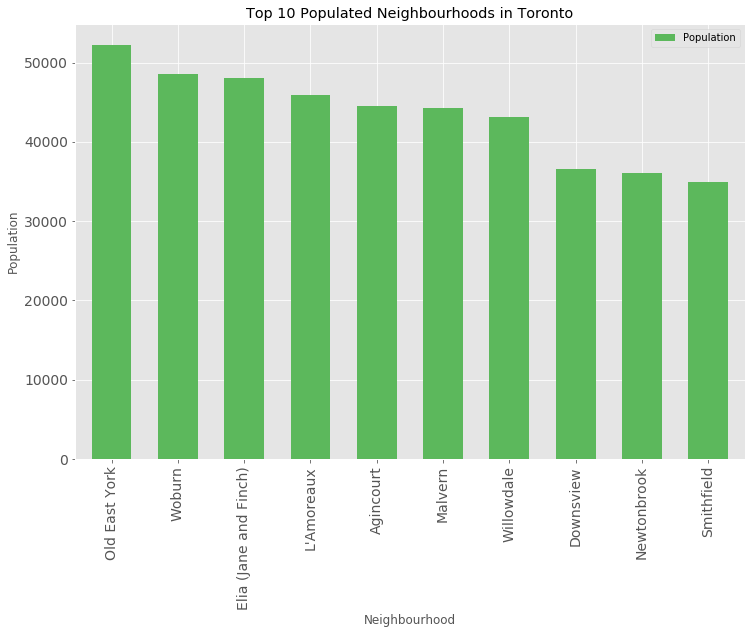

In [26]:
population_chart = df1[['Neighbourhood', 'Population']].copy()
top_chart = population_chart.head(10)
top_chart.set_index('Neighbourhood', inplace=True)

# plot data
colors = ['#5cb85c', '#5bc0de', '#d9534f']
top_chart.plot(kind='bar', figsize=(12, 8), width=0.6, fontsize=14, color=colors)

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Top 10 Populated Neighbourhoods in Toronto') # add title to the plot

plt.show()

<b>4. Segmenting and clustering in Toronto.</b>

In [27]:
# Use geopy library to get the latitude and longitude values of Toronto Ontario
address = 'Toronto Ontario, TO'
toronto_data = df1
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Ontario are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto Ontario are 43.638093, -79.4665843.


<b>4.1 - create the map of the Toronto Ontario and mark the neighbourhoods.</b>

In [28]:
# create map of Toronto Ontario using latitude and longitude values
map_to = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_to)  

map_to

<b>5. Adopting the Foursquare API to find out the venue category.</b>

In [30]:
# Foursquare Credentials
CLIENT_ID = 'RF2HLDBFJ0Z0IAOHHOTQG4CMUCDM0RGVAF3DVCQFD153FMOB' # your Foursquare ID
CLIENT_SECRET = '2LYBEQRR5TXMPQWUFKMLWCIKWVOA2G3U3Y1YCYL20MWXKRHJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: RF2HLDBFJ0Z0IAOHHOTQG4CMUCDM0RGVAF3DVCQFD153FMOB
CLIENT_SECRET:2LYBEQRR5TXMPQWUFKMLWCIKWVOA2G3U3Y1YCYL20MWXKRHJ


<b>5.1 Explore the first neighborhood in the dataframe.</b>

In [33]:
# explore the first neighborhood in our dataframe.
toronto_data.loc[1, 'Neighbourhood']
toronto_data.head(1)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.6964,-79.3297,2.161626


In [34]:
neighborhood_latitude = toronto_data.loc[1, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[1, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[1, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Agincourt are 43.788009, -79.283882.


<b>5.2 Explore the top venues from Foursquare API of radius of 500M.</b>

In [35]:
# explore the top 100 venues
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=RF2HLDBFJ0Z0IAOHHOTQG4CMUCDM0RGVAF3DVCQFD153FMOB&client_secret=2LYBEQRR5TXMPQWUFKMLWCIKWVOA2G3U3Y1YCYL20MWXKRHJ&v=20180605&ll=43.788009,-79.283882&radius=500&limit=100'

In [37]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ba993e84c1f6707cc982336'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Agincourt',
  'headerFullLocation': 'Agincourt, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 43.792509004500005,
    'lng': -79.2776601258366},
   'sw': {'lat': 43.7835089955, 'lng': -79.2901038741634}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5058e50ce4b0a3bd556ccbdf',
       'name': 'Tim Hortons',
       'location': {'address': '4200 Sheppard Ave East',
        'crossStreet': 'Midland Ave',
        'lat': 43.78563681034057,
        'lng': -79.27921459078789,


In [38]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [39]:
# clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Tim Hortons,Coffee Shop,43.785637,-79.279215


In [40]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

1 venues were returned by Foursquare.


In [43]:
# Explore Neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<b>5.3 Get nearby venues for Toronto neighbourhoods.</b>

In [ ]:
# get scarborough venues
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

print(toronto_venues.shape)
toronto_venues.head(10)

<b>5.4 Find out how many unique categories in the result.</b>

In [ ]:
# find out how many unique categories
toronto_venues.groupby('Neighbourhood').count()

In [46]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 303 uniques categories.


<b>5.5 Analyzing each neighborhood now in Toronto.</b>

In [47]:
# analyze each neighborhood

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Cafeteria,College Gym,College Lab,College Quad,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Ro

In [48]:
toronto_onehot.shape

(3406, 304)

<b>5.6 Group the rows together based on the mean of the frequency of occurrence of each category.</b>

In [49]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head(10)

,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Cafeteria,College Gym,College Lab,College Quad,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Ro

In [50]:
toronto_grouped.shape

(172, 304)

<b>5.7 Find out the top 10 most common venues in the neighbourhood.</b>

In [52]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [54]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
toronto_grouped.shape[0]
toronto_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Cafeteria,College Gym,College Lab,College Quad,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Street Art,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Ro

<b>5.8 Explore the top 8 venues for each neighborhood.</b>

In [56]:
# create the new dataframe and display the top 8 venues for each neighborhood.
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,Coffee Shop,Yoga Studio,Fast Food Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
1,Alderwood,Pizza Place,Gym,Dance Studio,Pub,Coffee Shop,Donut Shop,Bank,Convenience Store
2,Alexandra Park,Bar,Café,Vegetarian / Vegan Restaurant,Restaurant,Coffee Shop,French Restaurant,Dessert Shop,Yoga Studio
3,Allenby,Coffee Shop,Sushi Restaurant,Gym,Italian Restaurant,Café,Fruit & Vegetable Store,Liquor Store,Gastropub
4,Amesbury,Bakery,Fast Food Restaurant,Park,Sandwich Place,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant
5,Armour Heights,Wine Shop,Yoga Studio,Field,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
6,Banbury,Park,Yoga Studio,Fast Food Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
7,Bathurst Manor,Playground,Park,Baseball Field,Convenience Store,Food,Falafel Restaurant,Electronics Store,Empanada Restaurant
8,Bay Street Corridor,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Tea Room,Spa,Bubble Tea Shop,Burger Joint
9,Bayview Village,Golf Driving Range,Flower Shop,Trail,Yoga Studio,Farmers Market,Empanada Restaurant,Ethiopian Restaurant,Event Space


<b>5.9 Add the venue weighted score for each neighbourhood.</b>

In [57]:
neighborhoods_venues_sorted['Venue Score'] = 0
venue = 'Park'
venue_count = 0

# award the score based on the common findings
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains(venue), ['Venue Score']] = 1.0
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.9
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.8
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['4th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.7
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['5th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.6
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['6th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.5
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['7th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.4
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['8th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.3

# merge the two dataframes
merged_data = pd.merge(df1, neighborhoods_venues_sorted, on='Neighbourhood')

# clean up the merged dataset
merged_data = merged_data.drop('1st Most Common Venue', 1)
merged_data = merged_data.drop('2nd Most Common Venue', 1)
merged_data = merged_data.drop('3rd Most Common Venue', 1)
merged_data = merged_data.drop('4th Most Common Venue', 1)
merged_data = merged_data.drop('5th Most Common Venue', 1)
merged_data = merged_data.drop('6th Most Common Venue', 1)
merged_data = merged_data.drop('7th Most Common Venue', 1)
merged_data = merged_data.drop('8th Most Common Venue', 1)
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Venue Score', 1)

merged_data.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.6964,-79.3297,2.161626,0.0
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7675,-79.2177,2.007928,0.6
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7511,-79.5098,1.987065,0.0
3,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.796,-79.309,1.898439,0.0
4,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.788,-79.2839,1.845247,0.0
5,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.8092,-79.2217,1.834774,0.8
6,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.7712,-79.4197,1.785929,1.0
7,Downsview,36613,16.13,2270,-5.0,"26,751",14.4,Italian (11.7%),11.7% Italian,43.7323,-79.4934,1.515581,0.0
8,Newtonbrook,36046,8.77,4110,0.3,"33,428",16.6,Russian (8.8%),08.8% Russian,43.7901,-79.4197,1.492110,0.0
9,Smithfield,34996,6.45,5426,-7.2,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.7394,-79.5884,1.448645,0.0


<b>5.10 Calculate the total weighted score for each neighbourhood.</b>

In [58]:
# considering this to be a fair weightage on both parameters
population_weight = 0.5
venue_weight = 0.5

# calculate the total score
merged_data['Total Score'] = (merged_data['Population Score']*population_weight) + (merged_data['Venue Score']*venue_weight)

# sort the dataframe based on the descending total score
merged_data = merged_data.sort_values('Total Score', ascending=False)

<b>6. Cluster the neighbourhoods using K-Clustering.</b>

In [59]:
# set number of clusters
kclusters = 5

#toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# clean up data further
toronto_grouped_clustering = merged_data.drop('Neighbourhood', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Income', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Density', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('2nd Language', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('2nd Language %', 1)

toronto_grouped_clustering.head(10)

,Population,Land Area,Population %,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score
6,43144,7.68,62.3,15.6,43.7712,-79.4197,1.785929,1.0,1.392964
5,44324,8.86,1.5,13.6,43.8092,-79.2217,1.834774,0.8,1.317387
1,48507,13.34,-1.5,13.3,43.7675,-79.2177,2.007928,0.6,1.303964
0,52220,7.94,-4.6,22.0,43.6964,-79.3297,2.161626,0.0,1.080813
2,48003,7.66,-10.0,13.0,43.7511,-79.5098,1.987065,0.0,0.993533
21,25780,7.41,-3.6,18.2,43.7167,-79.2597,1.067153,0.9,0.983576
27,22746,2.18,-1.6,27.5,43.6595,-79.4676,0.941562,1.0,0.970781
3,45862,7.15,0.9,13.4,43.796,-79.309,1.898439,0.0,0.949220
20,26053,6.51,-4.0,10.6,43.6879,-79.5435,1.078454,0.8,0.939227
4,44577,12.45,4.6,11.1,43.788,-79.2839,1.845247,0.0,0.922624


In [60]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 1, 2, 3, 1, 3], dtype=int32)

<b>6.1 Clean up the data for clustering.</b>

In [61]:
# empty the invalid data
#merged_data['Neighbourhood'] = neighborhoods_venues_sorted['Neighbourhood']
#print(toronto_data.shape)
merged_data.isnull().sum()
merged_data.dropna(how = 'any', axis = 0, inplace = True)
print(merged_data.shape)
print(neighborhoods_venues_sorted.shape)

(172, 14)
(172, 9)


In [62]:
merged_data.head()

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score
6,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.7712,-79.4197,1.785929,1.0,1.392964
5,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.8092,-79.2217,1.834774,0.8,1.317387
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7675,-79.2177,2.007928,0.6,1.303964
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.6964,-79.3297,2.161626,0.0,1.080813
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7511,-79.5098,1.987065,0.0,0.993533


In [63]:
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Venue Score', 1)
neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,Coffee Shop,Yoga Studio,Fast Food Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
1,Alderwood,Pizza Place,Gym,Dance Studio,Pub,Coffee Shop,Donut Shop,Bank,Convenience Store
2,Alexandra Park,Bar,Café,Vegetarian / Vegan Restaurant,Restaurant,Coffee Shop,French Restaurant,Dessert Shop,Yoga Studio
3,Allenby,Coffee Shop,Sushi Restaurant,Gym,Italian Restaurant,Café,Fruit & Vegetable Store,Liquor Store,Gastropub
4,Amesbury,Bakery,Fast Food Restaurant,Park,Sandwich Place,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant


In [64]:
toronto_merged = toronto_data

# add clustering labels
merged_data['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = merged_data.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
6,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.7712,-79.4197,1.785929,1.0,1.392964,3,Park,Beach,Mediterranean Restaurant,Restaurant,Italian Restaurant,Yoga Studio,Ethiopian Restaurant,Event Space
5,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.8092,-79.2217,1.834774,0.8,1.317387,3,Pizza Place,Pharmacy,Park,Fast Food Restaurant,Sandwich Place,Grocery Store,Gym / Fitness Center,Bubble Tea Shop
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7675,-79.2177,2.007928,0.6,1.303964,3,Soccer Field,Coffee Shop,Business Service,Korean Restaurant,Park,Yoga Studio,Farmers Market,Empanada Restaurant
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.6964,-79.3297,2.161626,0.0,1.080813,3,Sandwich Place,Pizza Place,Pub,Liquor Store,Coffee Shop,Bakery,Greek Restaurant,Italian Restaurant
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7511,-79.5098,1.987065,0.0,0.993533,3,Plaza,Pool,Soccer Field,Italian Restaurant,Farmers Market,Electronics Store,Empanada Restaurant,Ethiopian Restaurant


<b>6.2 Draw the cluster map.</b>

In [67]:
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<b>7. Evaluate the final result.</b>

In [83]:
# display the top 5 neighbourhoods
target = merged_data.head(5)
target.head()
#toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].count()

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels
6,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.7712,-79.4197,1.785929,1.0,1.392964,3
5,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.8092,-79.2217,1.834774,0.8,1.317387,3
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7675,-79.2177,2.007928,0.6,1.303964,3
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.6964,-79.3297,2.161626,0.0,1.080813,3
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7511,-79.5098,1.987065,0.0,0.993533,3


In [93]:
# Cluster 1 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
60,Humbermede,14778,"24,297",11.8,Punjabi (9.7%),09.7% Punjabi,43.7421,-79.5407,0.611729,0.0,0.305865,0,Grocery Store,Discount Store,Café,Latin American Restaurant,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Space
61,St. James Town,14666,"22,341",27.4,Filipino (8.1%),08.1% Filipino,43.6709,-79.3733,0.607093,0.0,0.303547,0,Coffee Shop,Pizza Place,Caribbean Restaurant,Japanese Restaurant,Bike Rental / Bike Share,Library,Breakfast Spot,Food & Drink Shop
62,Cliffcrest,14531,"38,182",12.5,Tamil (1.5%),01.5% Tamil,43.7249,-79.2263,0.601505,0.0,0.300752,0,Bank,Flower Shop,Pharmacy,Coffee Shop,Bistro,Liquor Store,Fast Food Restaurant,Ethiopian Restaurant
63,Humber Valley Village,14453,"80,618",12.0,Ukrainian (3.9%),03.9% Ukrainian,43.6671,-79.528,0.598276,1.0,0.799138,0,Park,Skating Rink,Home Service,Fast Food Restaurant,Yoga Studio,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
64,Harbourfront / CityPlace,14368,"69,232",16.0,Unspecified Chinese (2.4%),02.4% Unspecified Chinese,43.6416,-79.3902,0.594758,0.6,0.597379,0,Hotel,Coffee Shop,Gym,Aquarium,Park,Sports Bar,Café,Baseball Stadium


In [94]:
# Cluster 2 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
7,Downsview,36613,"26,751",14.4,Italian (11.7%),11.7% Italian,43.7323,-79.4934,1.515581,0.0,0.757790,1,Baseball Field,Health & Beauty Service,Home Service,Business Service,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit
8,Newtonbrook,36046,"33,428",16.6,Russian (8.8%),08.8% Russian,43.7901,-79.4197,1.492110,0.0,0.746055,1,Café,Korean Restaurant,Coffee Shop,Pizza Place,Middle Eastern Restaurant,Grocery Store,Indian Restaurant,Sandwich Place
9,Smithfield,34996,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.7394,-79.5884,1.448645,0.0,0.724323,1,Grocery Store,Pizza Place,Fried Chicken Joint,Pharmacy,Coffee Shop,Fast Food Restaurant,Sandwich Place,Beer Store
10,Fairbank,34121,"28,403",21.6,Portuguese (11.3%),11.3% Portuguese,43.6964,-79.4563,1.412425,0.0,0.706213,1,Furniture / Home Store,Thai Restaurant,Bank,Grocery Store,Discount Store,Japanese Restaurant,Bike Shop,Pharmacy
11,Riverdale,31007,"40,139",20.0,Cantonese (6.7%),06.7% Cantonese,43.6697,-79.3532,1.283522,0.4,0.841761,1,Vietnamese Restaurant,Chinese Restaurant,Grocery Store,Baseball Field,Café,Bar,Park,Light Rail Station


In [95]:
# Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
27,High Park North,22746,"46,437",27.5,Polish (3.0%),03.0% Polish,43.6595,-79.4676,0.941562,1.0,0.970781,2,Park,Café,Italian Restaurant,Convenience Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit
28,Rouge,22724,"29,230",12.1,Tamil (15.6%),15.6% Tamil,43.8049,-79.1658,0.940651,0.9,0.920325,2,Fast Food Restaurant,Park,Yoga Studio,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
29,Eglinton East,22387,"25,307",19.4,Tamil (9.7%),09.7% Tamil,43.7248,-79.3051,0.926701,0.0,0.463350,2,Thrift / Vintage Store,Coffee Shop,Grocery Store,Bank,Pharmacy,Pet Store,Beer Store,Sandwich Place
30,East Danforth,21440,"33,847",24.2,Cantonese (4.2%),04.2% Cantonese,43.6838,-79.3212,0.887500,0.0,0.443750,2,Gastropub,Playground,Bank,Cosmetics Shop,Pizza Place,Dessert Shop,Cocktail Bar,Sandwich Place
31,Don Mills,21372,"47,515",10.8,Unspecified Chinese (3.9%),03.9% Unspecified Chinese,43.7448,-79.3409,0.884685,0.0,0.442343,2,Japanese Restaurant,Caribbean Restaurant,Café,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Exhibit


In [96]:
# Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Old East York,52220,"33,172",22.0,Greek (4.3%),04.3% Greek,43.6964,-79.3297,2.161626,0.0,1.080813,3,Sandwich Place,Pizza Place,Pub,Liquor Store,Coffee Shop,Bakery,Greek Restaurant,Italian Restaurant
1,Woburn,48507,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7675,-79.2177,2.007928,0.6,1.303964,3,Soccer Field,Coffee Shop,Business Service,Korean Restaurant,Park,Yoga Studio,Farmers Market,Empanada Restaurant
2,Elia (Jane and Finch),48003,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7511,-79.5098,1.987065,0.0,0.993533,3,Plaza,Pool,Soccer Field,Italian Restaurant,Farmers Market,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
3,L'Amoreaux,45862,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.796,-79.309,1.898439,0.0,0.949220,3,Chinese Restaurant,Bus Stop,Shopping Mall,Fast Food Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit
4,Agincourt,44577,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.788,-79.2839,1.845247,0.0,0.922624,3,Coffee Shop,Yoga Studio,Fast Food Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant


In [97]:
# Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
118,Little Italy,7917,"31,231",15.5,Portuguese (17.4%),17.4% Portuguese,43.6548,-79.4169,0.327721,0.0,0.163861,4,Italian Restaurant,Bar,Café,Sandwich Place,Coffee Shop,Burrito Place,Beer Bar,Clothing Store
119,The Danforth,7849,"44,979",23.3,Greek (7.4%),07.4% Greek,43.6838,-79.3212,0.324906,0.0,0.162453,4,Gastropub,Playground,Bank,Cosmetics Shop,Pizza Place,Dessert Shop,Cocktail Bar,Sandwich Place
120,Rosedale,7672,"213,941",11.3,Unspecified Chinese (1.0%),01.0% Unspecified Chinese,43.6834,-79.3772,0.317579,0.6,0.458790,4,Bank,Candy Store,Playground,Grocery Store,Park,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
121,Humberwood,7319,"29,576",7.9,Punjabi (26.7%),26.7% Punjabi,43.7257,-79.6193,0.302967,0.7,0.501484,4,Dance Studio,Bus Station,Gym / Fitness Center,Park,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Space
122,Discovery District,7262,"41,998",12.7,Unspecified Chinese (6.5%),06.5% Unspecified Chinese,43.6603,-79.3937,0.300608,0.0,0.150304,4,Coffee Shop,Café,Japanese Restaurant,Ice Cream Shop,Italian Restaurant,Sandwich Place,Korean Restaurant,Chinese Restaurant


<b>8. Final Analysis</b>

Based on the result above, the first cluster (i.e. 0) looks to offer a higher number of similar neighborhoods and allow ABC Grocery to replicate their business offering quickly (due to the similarities in these neighborhoods) as part of their growth plan.

Within the first cluster, we will like to recommend a neighborhood with higher demand and lower supply to give ABC Grocery a higher advantage and chance to succeed upon their first service offering. Hence, with this in mind, it is apparent that neighborhood Humbermede looks to be the choice as it is the highest populated (i.e. 14,778) and very few Grocery stores in the neighborhood (i.e. close to none for the first few most common venues in this neighborhood). 

It is also apparent that there is a high number of Punjabi people in that neighborhood and hence, we will also like to encourage the management of ABC Grocery to offer Punjabi food or related supplies in their service offerings in that neighborhood.

With that, we have concluded that the best recommendation for ABC Grocery to first offer their services in Toronto will be neighborhood Humbermede with the key factors to consider such as higher demand, lower competition, easy replication for business expansion. See the recommendation summary below.

1.	Region: First Cluster.
2.	Neighborhood: Humbermede
3.	Additional Offering: Punjabi food or related supplies.

It is also recommended to the management of ABC Grocery to re-run this data science program to get the updated result and use the result into consideration as part of the business growth plan in selecting the next neighborhood to offer their services. This is critical not only to make sure that they got the updated result for better decision making, but also to make sure that they can re-validate the findings from this project. Finally, thank you for the opportunity in this project and we wish you the best success in your business.